### <center>Ângelo Pascoal Figueiral, 44645</center>

# Assignment 3

The assignment 3 contains 1 question and the due date is April 18th (Sunday) 23:59PM.

## Question 1 

We use true financial audit dataset for modelling productive and non-productive audits of a person's financial statement. A productive audit is one which identifies errors or inaccuracies in the information provided by a client. A non-productive audit is usually an audit which found all supplied information to be in order.


- Age: The age.
- Employment: The type of employment.
- Education: The highest level of education.
- Marital: Current marital status.
- Occupation: The type of occupation.
- Income: The amount of income declared.
- Gender: The persons gender.
- Deductions: Total amount of expenses that a person claims in their financial statement.
- Hours: The average hours worked on a weekly basis.
- TARGET_Adjusted: This is a numeric field of class integer, but limited to 0 and 1, indicating non-productive and productive audits, respectively. Productive audits are those that result in an adjustment being made to a client's financial statement.

### Question 1.1 (20 points)
Read the data from audit.csv. Implement a preprocessing pipeline to separately transform the categorical features `Employment`, `Education`, `Marital`, `Occuptation`, `Gender`, `Deduction` and numeric features `Income` and `Hours`. For categorical features, perform one-hot encoding. For numerical features, perform standardization. For `Age`, build a custom transformer to make the age group feature [17-30, 30-50, 50-83] and then one-hot encode the age group. Report the shape of the transformed train set.

In [30]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

audit = pd.read_csv('audit.csv')
audit.head()

X, y = audit.loc[:,'Age':'Hours'], audit.loc[:,'Adjusted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"X_train shape:{X_train.shape}\nX_test shape:{X_test.shape}\ny_train shape:{y_train.shape}\ny_test shape:{y_test.shape}")

X_train shape:(1519, 9)
X_test shape:(380, 9)
y_train shape:(1519,)
y_test shape:(380,)


In [31]:
# Checking if there are any missing values
audit_incomplete_rows = audit[audit.isnull().any(axis=1)]
audit_incomplete_rows

#there are no missing values, meaning we can proceed

,Age,Employment,Education,Marital,Occupation,Income,Gender,Deductions,Hours,Adjusted


In [32]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

num_attribs = ['Income', 'Hours']
cat_attribs = ['Employment', 'Education', 'Marital', 'Occupation', 'Gender', 'Deductions']
    


# creating function to create the bins for the age data
def age_bins_creator(col):
    ages = pd.DataFrame(data = col, columns = ['Age'])
    age_cats = pd.cut(ages["Age"], bins=[17., 30., 50., 83.], right= False, labels=['17-30', '30-50', '50-83'])
    age_cats_df = pd.DataFrame(data = age_cats, columns = ['Age'])
    return age_cats_df


# creating a class to select numerical and categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values    
    
    
age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age'])),
    ('age_transformer', FunctionTransformer(age_bins_creator, validate = False)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('age_enconder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

pre_processing_pipeline = FeatureUnion(transformer_list=[
        ('age_pipeline', age_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [33]:
# Applying the pipeline
from sklearn.pipeline import FeatureUnion

audit_prepared = pre_processing_pipeline.fit_transform(X)

In [34]:
# Exploring audit_prepared
len(audit_prepared[0])

52

### Question 1.2 (10 points)

Now add a LogisticRegression model to the pipeline to fit the train set and report the predictive precision, recall and f1 score on the test set.  

In [35]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg_pipeline = Pipeline([
    ('preprocessing', pre_processing_pipeline),
    ('lr', log_reg)
])

model = log_reg_pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [36]:
from sklearn.metrics import f1_score, recall_score, precision_score

print(f"""F1_Score: {round(f1_score(y_test, y_pred), 2)}
Recall: {round(recall_score(y_test, y_pred), 2)}
Precision: {round(precision_score(y_test, y_pred), 2)}
""")

F1_Score: 0.63
Recall: 0.55
Precision: 0.75



### Question 1.3 (20 points)

Now use the sklearn.decomposition.PCA to perform principal component analysis on the data and explain which number of principal components should be chosen using Elbow method if PCA reaches 90% threshold of explained variance. Add the PCA to the preprocessing pipeline and use Logistic Regression to fit the train set. Report the predictive precision, recall and f1 score on the test set. Explain whether you would be able to achieve a better result.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)

X_reduced = pca.fit_transform(audit_prepared)

print(f"Number of principal components to be used for a 90% threshold of explained variance: {pca.n_components_}")

Number of principal components to be used for a 90% threshold of explained variance: 20


In [38]:
pca_pipeline = Pipeline([ 
    ('preprocessing', pre_processing_pipeline),
    ('pca', pca),
    ('lr', log_reg),
])

model = pca_pipeline.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [39]:
from sklearn.metrics import f1_score, recall_score, precision_score

print(f"""F1_Score: {round(f1_score(y_test, y_pred), 2)}
Recall: {round(recall_score(y_test, y_pred), 2)}
Precision: {round(precision_score(y_test, y_pred), 2)}
""")

F1_Score: 0.64
Recall: 0.55
Precision: 0.76



## Answer:

- Adding Principal Component Analysis to the pipeline improved the model very slightly. In fact, the increase is so small that it is unclear whether PCA actually improves the model.

---

### Question 1.4 (10 points)

Now fine-tune the n_compnents from 1 to 50 in the pca using a grid search strategy through 5-fold cross-validation (with the f1 as the scoring function). Plot the `mean test score` for grid searched n_components. Expalin whether the best estimator obtained from fine-tuning process is the same n_components from the previous question. Also, report predictive precision, recall and f1 score on the test set. 

In [40]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

param_grid = {
    'pca__n_components': range(1,50),
}

grid_search = GridSearchCV(pca_pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

print(f"After Grid Search fine-tuning: {grid_search.best_params_}")

After Grid Search fine-tuning: {'pca__n_components': 19}


In [41]:
y_axis = grid_search.cv_results_['mean_test_score']
x_axis = range(1,50)

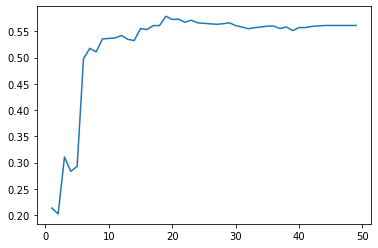

In [42]:
plt.plot(x_axis, y_axis)

In [43]:
y_pred = grid_search.predict(X_test)

In [44]:
from sklearn.metrics import f1_score, recall_score, precision_score

print(f"""F1_Score: {round(f1_score(y_test, y_pred), 2)}
Recall: {round(recall_score(y_test, y_pred), 2)}
Precision: {round(precision_score(y_test, y_pred), 2)}
""")

F1_Score: 0.63
Recall: 0.53
Precision: 0.76



## Answer:

- After fine-tuning, the number of principal components decreased by 1 (from 20 in 1.3 to 19 after fine-tuning).

---

### Question 1.5 (10 points) 
Add the PCA transformed features to the preprocessing pipeline, fine-tune again the n_components and report the best estimator obtained same as above. In other words, both the preprocessed features and PCA-processed features will be concatenated togehter. Explain whether adding PCA transformed feature would help increase model performance. Also, report predictive precision, recall and f1 score on the test set. (Hint: use FeatureUnion to concatenate the features)

In [45]:
age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age'])),
    ('age_transformer', FunctionTransformer(age_bins_creator, validate = False)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('age_enconder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

pre_processing_pipeline = FeatureUnion(transformer_list=[
        ('age_pipeline', age_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

pca_pipeline = Pipeline([ 
    ('preprocessing', pre_processing_pipeline),
    ('pca', pca),
])

concatenated_pipeline = FeatureUnion(transformer_list=[
    ('pre_processing_pipeline', pre_processing_pipeline),
    ('pca_pipeline', pca_pipeline),
    ])


audit_prepared = concatenated_pipeline.fit_transform(X)


pca = PCA(n_components=0.9)
log_reg = LogisticRegression()

model_pipeline = Pipeline([ 
    ('concatenated_pipeline', concatenated_pipeline),
    ('lr', log_reg),
])

In [46]:
audit_prepared.shape

(1899, 72)

In [47]:
param_grid = {
    'concatenated_pipeline__pca_pipeline__pca__n_components': range(1,50),
}

grid_search = GridSearchCV(model_pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

print(f"After Grid Search fine-tuning: {grid_search.best_params_}")

After Grid Search fine-tuning: {'concatenated_pipeline__pca_pipeline__pca__n_components': 29}


Ideal number of principal components increased by 9 from the previous method.

In [48]:
from sklearn.metrics import f1_score, recall_score, precision_score

y_pred = grid_search.predict(X_test)

print(f"""F1_Score: {round(f1_score(y_test, y_pred), 2)}
Recall: {round(recall_score(y_test, y_pred), 2)}
Precision: {round(precision_score(y_test, y_pred), 2)}
""")

F1_Score: 0.63
Recall: 0.55
Precision: 0.73



## Answer:

- In this case, GridSearchCV returns an optimal number of features of 29.
- When considereing the difference in recall, precision, and F1 scores, we can conclude that this does not improve our model.

- Moreover, adding the PCA features will result in a more complex and slower model without adding anything in return.

---

### Question 1.6 (20 points)

Now build a pipeline with the stacking model as the last step that takes the random forest, adaboost, gradient boost and KNN models as the base estimator and Logistic regression as the final estimator. Fine-tune the model using the hyperparameters for all these models and report the predicted precision, recall and f1 score on test set (you should be able to achieve comparable performance).

In [49]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, \
                            GradientBoostingClassifier, StackingRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

ada_boost_pipeline = make_pipeline(concatenated_pipeline,
                               AdaBoostClassifier())

rf_pipeline = make_pipeline(concatenated_pipeline,
                            RandomForestClassifier(random_state=0))

gradient_pipeline = make_pipeline(
    concatenated_pipeline,
    GradientBoostingClassifier())

knn_pipeline = make_pipeline(
    concatenated_pipeline,
    KNeighborsClassifier())

estimators = [('rf', rf_pipeline),
              ('ada_boost', ada_boost_pipeline),
              ('Gradient Boosting', gradient_pipeline),
             ('knn', knn_pipeline)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=LogisticRegression())

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV

estimators = [
    ('ada_boost', AdaBoostClassifier()),
    ('rf', RandomForestClassifier(random_state=0)),
    ('gradient', GradientBoostingClassifier(random_state=0)),
    ('knn', KNeighborsClassifier())
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator= LogisticRegression(),
)

In [51]:
age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age'])),
    ('age_transformer', FunctionTransformer(age_bins_creator, validate = False)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('age_enconder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
    
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown = "ignore")),
])

pre_processing_pipeline = FeatureUnion(transformer_list=[
        ('age_pipeline', age_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


In [52]:
final_pipeline = Pipeline([
    ('pre_processing_pipeline', concatenated_pipeline),
    ('reg', stacking),
    ])

In [53]:
params = {
    'reg__rf__n_estimators': range(1,5),
    'reg__ada_boost__n_estimators': range(1,5),
    'reg__gradient__n_estimators': range(1,5),
    'reg__knn__n_neighbors': range(1,5),
}
# wider ranges should have been used, but running that took too much time

grid = GridSearchCV(final_pipeline, param_grid=params, scoring='f1',cv=2)

In [54]:
grid.fit(X_train, y_train)
print(grid.best_params_)

{'reg__ada_boost__n_estimators': 1, 'reg__gradient__n_estimators': 4, 'reg__knn__n_neighbors': 4, 'reg__rf__n_estimators': 3}


### Question 1.7 (10 points)
Once the final model is obtained, export the model as a pickle, and show you can make the predictions on the following observations without having to retrain (you should expect to get the predicted value of 0).

In [55]:
X_news = pd.DataFrame({
    'Age': 45,
    'Employment': 'Private',
    'Education': 'College',
    'Marital': 'Divorced',
    'Occupation': 'Support',
    'Income': 125370,
    'Gender': 'Female',
    'Deductions': False,
    'Hours': 40}, index=[0])
X_news

,Age,Employment,Education,Marital,Occupation,Income,Gender,Deductions,Hours
0,45,Private,College,Divorced,Support,125370,Female,False,40


In [56]:
# Saving the model through Pickle
import pickle

pickled_model = grid.best_estimator_

with open("pickled_model.pkl", "wb") as file:
    pickle.dump(pickled_model, file)

In [57]:
# Loading the model
my_pipeline = pickle.load(open("pickled_model.pkl","rb"))

final_predictions = my_pipeline.predict(X_news)

final_predictions

array([0], dtype=int64)